### Standard imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Define the dataset and generate the pairs on-the-fly

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.85882354].


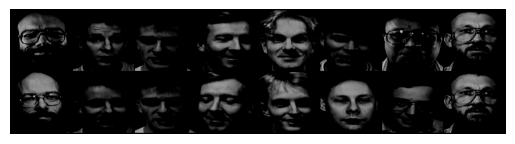

[0. 0. 0. 0. 1. 1. 0. 0.]


In [4]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [5]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [6]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [7]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 10.146495819091797



/home/fabian/MasterStudium/PythonEnvrionment/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch number 1
 Current loss 7.046335220336914

Epoch number 2
 Current loss 8.339377403259277

Epoch number 3
 Current loss 5.467419147491455

Epoch number 4
 Current loss 6.334549903869629

Epoch number 5
 Current loss 5.136133193969727

Epoch number 6
 Current loss 4.697962760925293

Epoch number 7
 Current loss 4.385462284088135

Epoch number 8
 Current loss 3.660560131072998

Epoch number 9
 Current loss 2.793814182281494

Epoch number 10
 Current loss 3.225325584411621

Epoch number 11
 Current loss 2.2734193801879883

Epoch number 12
 Current loss 2.6070079803466797

Epoch number 13
 Current loss 3.023853063583374

Epoch number 14
 Current loss 2.0497167110443115

Epoch number 15
 Current loss 1.900628685951233

Epoch number 16
 Current loss 1.3511695861816406

Epoch number 17
 Current loss 2.624795436859131

Epoch number 18
 Current loss 1.9640905857086182

Epoch number 19
 Current loss 1.7305858135223389

Epoch number 20
 Current loss 1.7345938682556152

Epoch number 21
 Curre

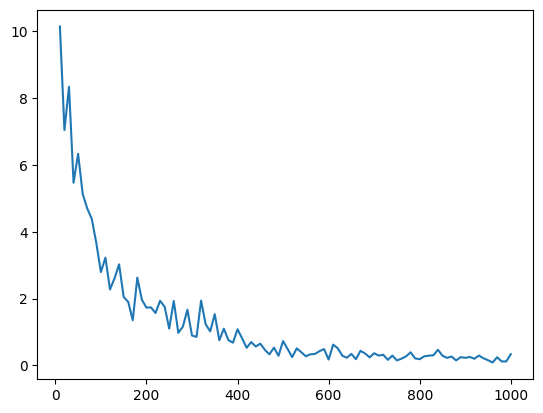

In [8]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.81960785].


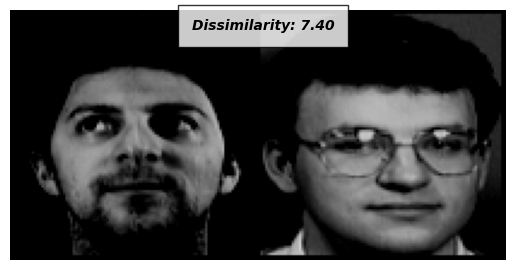

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.8117647].


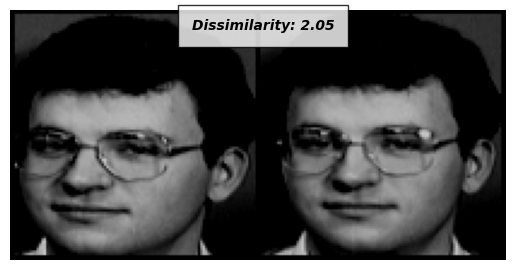

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.79607844].


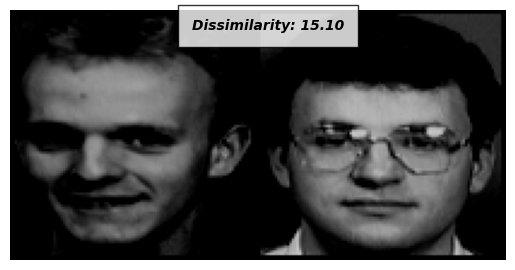

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.8509804].


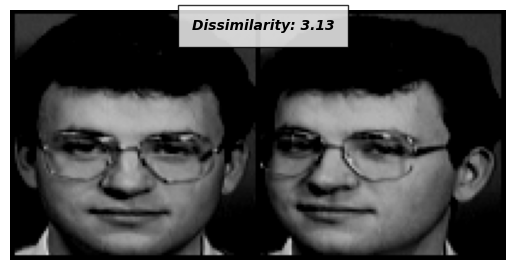

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.8509804].


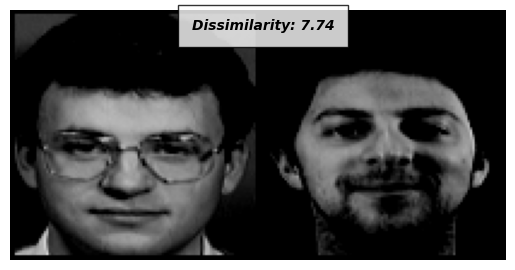

In [9]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)


for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

### Offline triplet generation

In [11]:
import os 
import random
def triplets(folder_paths, max_triplets=20):
    anchor_images = []
    positive_images = []
    negative_images = []

    for person_folder in folder_paths:
        images = [os.path.join(person_folder, img)
                  for img in os.listdir(person_folder)]
        num_images = len(images)

        if num_images < 2:
            continue

        random.shuffle(images)

        for _ in range(max(num_images-1, max_triplets)):
            anchor_image = random.choice(images)

            positive_image = random.choice([x for x in images
                                            if x != anchor_image])

            negative_folder = random.choice([x for x in folder_paths
                                             if x != person_folder])
            
            
            negative_image = random.choice([os.path.join(negative_folder, img)
                                            for img in os.listdir(negative_folder)])

            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    return anchor_images, positive_images, negative_images

DATASET = "./data/faces/training/"

person_folders = [os.path.join(DATASET, folder_name)
                  for folder_name in os.listdir(DATASET)]

anchors, positives, negatives = triplets(person_folders,max_triplets=50)

print(f"Number of triplets: {len(anchors)}")
print(f"Example triplet: {anchors[1]}, {positives[1]}, {negatives[1]}")

Number of triplets: 1850
Example triplet: ./data/faces/training/s11/7.pgm, ./data/faces/training/s11/4.pgm, ./data/faces/training/s34/3.pgm


### Task 1: Define the dataset for TripletNetwork

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.85882354].


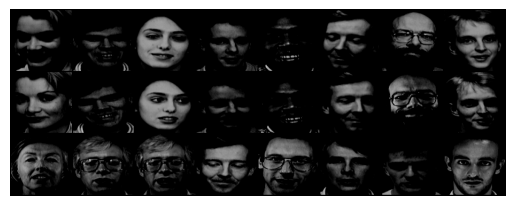

In [14]:
#############################################
## TODO: Implement the TripletNetworkDataset
class TripletNetworkDataset(Dataset):
    def __init__(self, anchors, positives, negatives, transform=None):
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives

        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((100,100)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.5],std=[0.5])
                                                ])

    def __getitem__(self,index):
        anchor = self.transform(Image.open(self.anchors[index]))
        positive = self.transform(Image.open(self.positives[index]))
        negative = self.transform(Image.open(self.negatives[index]))

        return anchor, positive, negative

    def __len__(self):
        return len(self.anchors)
    
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

## TODO: Initialize the dataset
# Define the dataset
triplet_dataset = TripletNetworkDataset(anchors=anchors, positives=positives, negatives=negatives, transform=transformation)

# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(triplet_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 3x8 images, indexes 0,1,3
concatenated = torch.cat((example_batch[0], example_batch[1],example_batch[2]),0)

imshow(torchvision.utils.make_grid(concatenated))


### Task 2: Implement the TripletSiameseNetwork

In [22]:
triplet_loss = nn.TripletMarginLoss(margin=1, p=2, eps=1e-7)
train_dataloader_triplet = DataLoader(triplet_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

#######################################################
## TODO: Implement the TripletNetwork
#create the Siamese Neural Network
class TripletSiameseNetwork(nn.Module):

    def __init__(self):
        super(TripletSiameseNetwork, self).__init__()
        
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3,stride=1),         
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2, stride=2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),            
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2, stride=2),

            torch.nn.Conv2d(128, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2, stride=2),
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(6400, 4096),       
            torch.nn.Linear(4096, 2048),            
            torch.nn.Linear(2048,1024)
        )

    def forward(self, x1, x2, x3):
        x1 = self.cnn1(x1)
        x1= x1.view(x1.size()[0], -1)
        x1 = self.fc1(x1)

        x2 = self.cnn1(x2)
        x2= x2.view(x2.size()[0], -1)
        x2 = self.fc1(x2)

        x3 = self.cnn1(x3)
        x3= x3.view(x3.size()[0], -1)
        x3 = self.fc1(x3)

        return x1, x2, x3
        


net = TripletSiameseNetwork().cuda()
criterion_triplet = triplet_loss
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

torch.Size([64, 1, 100, 100])
Epoch number 0
 Current loss 0.9553660154342651

torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
Epoch number 0
 Current loss 0.08326330780982971

torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
Epoch number 0
 Current loss 0.10011555999517441

torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size([64, 1, 100, 100])
torch.Size(

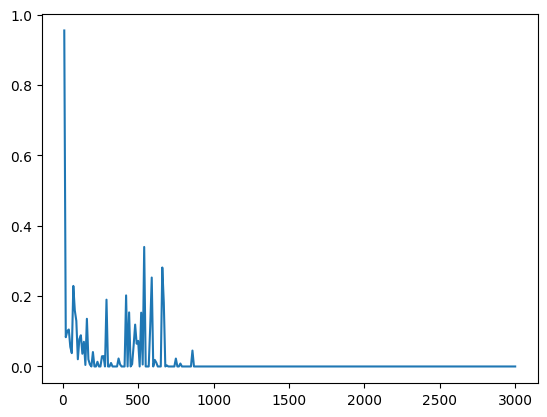

In [23]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, img2) in enumerate(train_dataloader_triplet, 0):

        # Send the images and labels to CUDA
        img0, img1, img2 = img0.cuda(), img1.cuda(), img2.cuda()
        
        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output0, output1, output2 = net(img0, img1,img2)

        # Pass the outputs of the networks and label into the loss function
        loss_triplet = criterion_triplet(output0, output1, output2)

        # Calculate the backpropagation
        loss_triplet.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_triplet.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_triplet.item())

show_plot(counter, loss_history)

/home/fabian/MasterStudium/PythonEnvrionment/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.8039216].


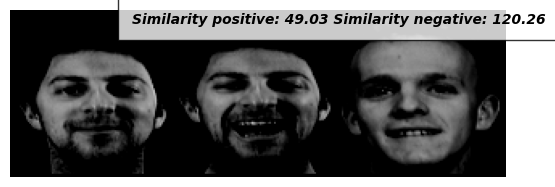

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.8509804].


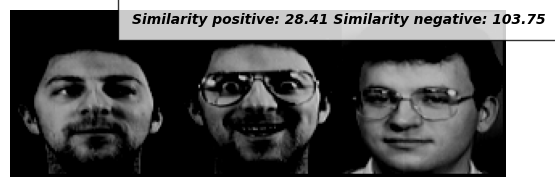

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.81960785].


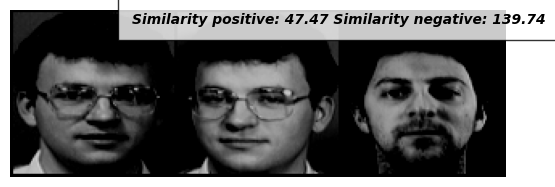

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.78039217].


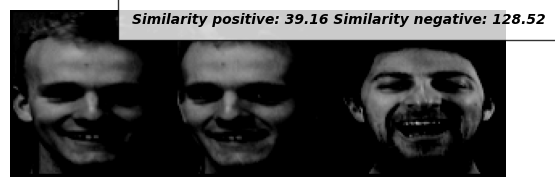

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.81960785].


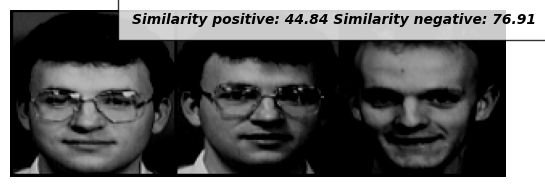

In [24]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = "./data/faces/testing/"
person_folders = [os.path.join(folder_dataset_test, folder_name)
                  for folder_name in os.listdir(folder_dataset_test)]
test_triplets_a, test_triplets_p,test_triplets_n = triplets(person_folders)
triplet_dataset_test = TripletNetworkDataset(test_triplets_a, test_triplets_p,test_triplets_n,
                                        transform=transformation)
test_dataloader = DataLoader(triplet_dataset_test, num_workers=2, batch_size=1, shuffle=True)

# Create a simple dataloader just for simple visualization
vis_dataloader1 = DataLoader(triplet_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=1)


# Grab one image that we are going to test
dataiter = iter(test_dataloader)

net.eval()
for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, x2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1,x2))
    
    output0, output1, output2 = net(x0.cuda(), x1.cuda(),x2.cuda())
    euclidean_distance_positive = F.pairwise_distance(output0, output1)
    euclidean_distance_negative = F.pairwise_distance(output0, output2)

   
    imshow(torchvision.utils.make_grid(concatenated), f'Similarity positive: {euclidean_distance_positive.item():.2f} Similarity negative: {euclidean_distance_negative.item():.2f}')